In [1]:
# Importación de librerias.
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt

# Carga del dataset. 
analogias_df = pd.read_csv('analogies_answers.csv')
analogias_df.head()

,cueEjemplo,targetEjemplo,cue,response,count,rank,porcentaje
0,bailarín,bailar,albañil,construir,1,1.0,100.0
1,pistola,bala,arco,flecha,1,1.0,100.0
2,picnic,parque,asado,parrillero,1,1.0,100.0
3,pirámide,momia,ataúd,cadáver,1,1.0,100.0
4,tren,vías,auto,carretera,1,1.0,100.0


In [2]:
# Embeddings utilizados.
embeddings_WIKI = KeyedVectors.load_word2vec_format('embeddings/wiki.es.vec', limit=None)
embeddings_SUC = KeyedVectors.load_word2vec_format('embeddings/embeddings-l-model.vec', limit=None)
embeddings_SWOW = KeyedVectors.load_word2vec_format('embeddings/swow.embedding.was.26-04-2022.vec', limit=None)
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
embeddings_SBWC = KeyedVectors.load_word2vec_format('embeddings/SBW-vectors-300-min5.txt', limit=None)
embeddings_Glove = KeyedVectors.load_word2vec_format('embeddings/glove-sbwc.i25.vec', limit=None)

In [3]:
# Embedding SWOW pasado a minusculas 

# Vectores y palabras del SWOW.
palabras = list(embeddings_SWOW.key_to_index.keys())
vectores = list(embeddings_SWOW.vectors)

# Convertir todas las palabras a minúsculas.
palabras_minusculas = [palabra.lower() for palabra in palabras]

# Creación de un nuevo modelo SWOW con las palabras y vectores en minúsculas. 
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
lower_embeddings_SWOW.add_vectors(palabras_minusculas, vectores)

In [4]:
# Listado de los embeddings utilizados. 
#lista_de_Embeddings = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove]
#lista_de_Embeddings = [lower_embeddings_SWOW, embeddings_Glove]
lista_de_Embeddings = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove

In [5]:
# Calculo de la frecuencia de las combinaciones de 'cue' y 'response' y sus rangos para identificar las analogías más relevantes
analogias_df['count'] = analogias_df.groupby(['cue','response'])['response'].transform('count')
analogias_df['rank'] = analogias_df.groupby('cue')['count'].rank(ascending=False, method='min')

# Calculo del porcentaje de frecuencia de cada combinación en relación con el número total de respuestas para ese 'cue'.
total_respuestas = analogias_df.groupby('cue')['response'].transform('count')
analogias_df['porcentaje'] = (analogias_df['count'] / total_respuestas) * 100

# Indices de filas que tienen rango minimo (rango 1).
idx = analogias_df.groupby(['cue'])['rank'].idxmin()

# Me quedo unicamente con las filas que tienen las combinaciones más relevantes según el rango.
analogias_df = analogias_df.loc[idx]

# Se guarda el DataFrame modificado en un archivo CSV.
analogias_df.to_csv('analogies_answers.csv', index=False)

# Se pasan todas las palabras a minúsculas. 
analogias_df['cueEjemplo'] = analogias_df['cueEjemplo'].apply(lambda x: str(x).lower())
analogias_df['targetEjemplo'] = analogias_df['targetEjemplo'].apply(lambda x: str(x).lower())
analogias_df['cue'] = analogias_df['cue'].apply(lambda x: str(x).lower())

# Se realizan los reemplazos necesarios. 
analogias_df['cueEjemplo'] = analogias_df['cueEjemplo'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogias_df['targetEjemplo'] = analogias_df['targetEjemplo'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogias_df['cue'] = analogias_df['cue'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')


## Filtrar: sólo las analogías que tengan todas las palabras en todos los embeddings

In [127]:
# Filtrar filas que tengan todas las palabras en todos los embeddings

# "all" combina los valores booleanos de word in e.key_to_index, para todos los embeddings e
# luego, se forma un valor para cada fila de cada una de las 4 columnas
columns = ['cueEjemplo', 'targetEjemplo','cue','response']
filtro = [ [ all(word in e.key_to_index  for e in lista_de_Embeddings) for word in analogias_df[column]] for column in columns]
# me quedo sólo con las que tienen todas las palabras en todos los embeddings
filtro = [a & b & c & d for a,b,c,d in zip(filtro[0],filtro[1],filtro[2],filtro[3])]

analogias_df = analogias_df[filtro]

## Calculo una vez las predicciones, K=25

In [129]:
#from mis_funciones import metricas_topK, calcular_predicciones

K_fijo = 25
todas_predicciones = [calcular_predicciones(e, analogias_df, K_fijo) for e in lista_de_Embeddings] 
# es una lista de listas, cada lista en todas_predicciones contiene las predicciones generadas para cada embedding en específico
# Se itera sobre cada modelo de embedding (e) en lista_de_Embeddings y se llama a la función calcular_predicciones con ese modelo, el df analogias_df y el valor de K_fijo
# Se generan predicciones para cada fila en analogias_df utilizando el embedding 



### Pero luego calculo varios valores de K, simplemente recortando la lista de predicciones

In [130]:
# en base aun únic cálculo de predicciones, calcular las métricas para diferentes valores de K
Ks = [5, 10, 15, 20, 25]
topK_metricas = [[metricas_topK(prediccion, analogias_df,K)  for K in Ks] for prediccion in todas_predicciones]
# lista que almacena las métricas calculadas por metricas_topK para cada conjunto de predicciones en todas_predicciones
# Se itera sobre cada conjunto de predicciones en todas_predicciones y se llama a la función metricas_topK con ese conjunto de predicciones y el df analogias_df. 
# Se calcula la métrica de precisión top-K para cada conjunto de predicciones y devuelve una lista de estas métricas, cada valor representa la precisión top-K para un modelo de embedding específico



59
59
59
59
59
59
59
59
59
59


/tmp/ipykernel_141644/918691228.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analogias_df['response'] = analogias_df['response'].fillna('') # se llenan los valores nulos en la columna 'response'
/tmp/ipykernel_141644/918691228.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analogias_df['response'] = analogias_df['response'].apply(lambda x: str(x)) # chequeamos de que todos los valores sean strings


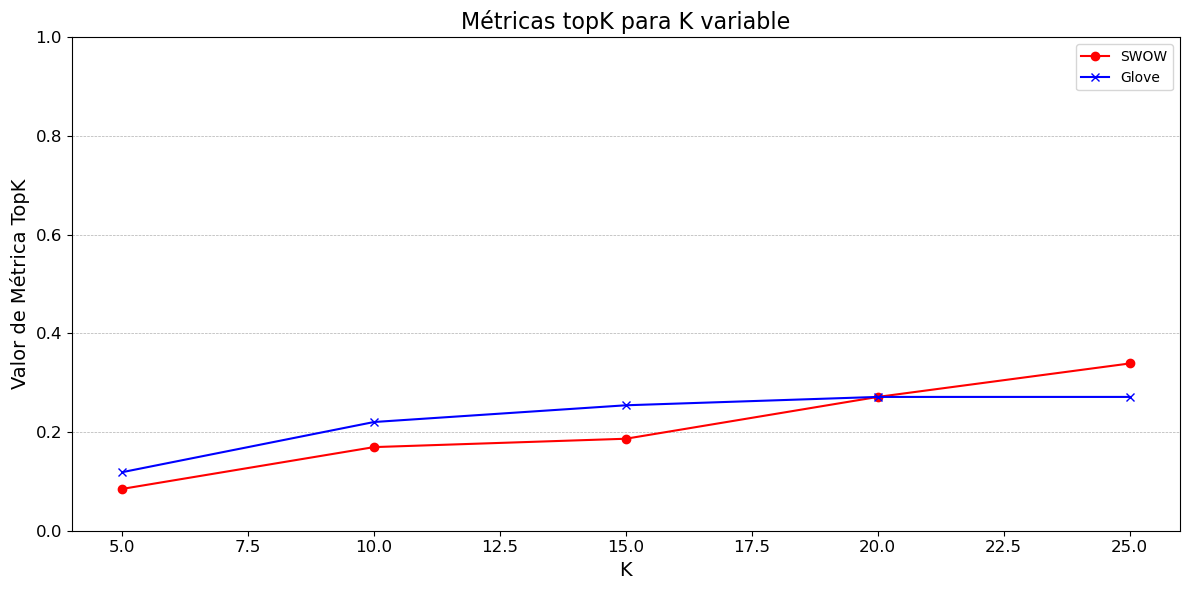

In [133]:
# datos para el valor de K fijo
#data_fijo = topK_metricas_fijo

# Nombres de embeddings
lista_de_Nombres = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Colores para plotear
colors = ['red', 'blue','green','black','pink']


# marcadores para usar
markers = ['o', '^', 's','+','x']  # Markers for each category



# numero de embeddings
num_embeddings = len(lista_de_Nombres)

#width = 0.2

# Crear la figura para los datos del valor de K fijo
fig, ax = plt.subplots(figsize=(12, 6))

# valores de x para cada barra
x = np.arange(num_embeddings)

#bar = ax.bar(x, data_fijo, width, color='pink', edgecolor='black')
for i, emb in enumerate(lista_de_Nombres):
    plt.plot(Ks, topK_metricas[i], color=colors[i], label=lista_de_Nombres[i],marker=markers[i])


# Etiquetas 
ax.set_xlabel('K', fontsize=14)
ax.set_ylabel('Valor de Métrica TopK', fontsize=14)
ax.set_title(f'Métricas topK para K variable', fontsize=16)
#ax.set_xticks(x)
#ax.set_xticklabels(lista_de_Nombres, rotation=45, fontsize=12)

# Limitar el eje y entre 0 y .6
ax.set_ylim([0, .6])

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.legend()
plt.show()
